####  data load
https://storage.cloud.google.com/cartoonset_public_files/cartoonset10k.tgz

#### 
https://github.com/dtrckd/simplon_datai_2020/blob/master/brief_10/brief.md




Schématiquement, le GAN se présente comme suit :
    1. Un réseau generator fait correspondre des vecteurs de forme (latent_dim,) à des images de forme
(32, 32, 3) .

    2. Un réseau discriminator fait correspondre des images de forme (32, 32, 3) à un score binaire qui estime la probabilité que l'image soit réelle.
estimant la probabilité que l'image soit réelle.

    3.Un réseau gan enchaîne le generator et le discriminator :                    gan(x) = discriminator(générateur(x)) . 
Ainsi, ce réseau gan fait correspondre les vecteurs de l'espace latent_dim  à l'évaluation par le discriminator 

    4.Vous entraîne le discriminator à l'aide d'exemples d'images réelles et fausses avec desdes étiquettes
 "vrai"/"faux", comme on entraîne un modèle de classification d'images classique.
    5. Pour entraîner le generator, on utilise les gradients des poids du générateur par rapport à la perte du modèle gan. Cela signifie, qu'à chaque étape, on déplace les les poids du générator dans une direction qui rend le discriminator plus susceptible de de classer comme "réelles" les images décodées par le générateur. En d'autres termes, on entraîne le générateur à tromper le discriminator.



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!pwd


/home/sacia/Documents/WorkSpace/BriefAvatar


In [3]:
#current_path = os.path.join(src, animal)
path = "./dataR/cartoonset50"
def nbr_file(path):
  list_file=[] 
  for file in os.listdir(path):
      list_file.append(file)
  return len(list_file) 
nbr = nbr_file(path)
nbr

130

In [2]:
# Test on 130 instead of 10 000 images
dataset = keras.preprocessing.image_dataset_from_directory(
    "dataR", label_mode=None, image_size=(32, 32), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 130 files belonging to 1 classes.


In [3]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.MapDataset

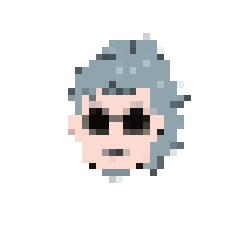

In [4]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


### GAN generator network
DeepLearning book F. Chollet

In [5]:
import keras
from keras import layers
import numpy as np
latent_dim = 32
height = 32
width = 32
channels = 3


generator_input = keras.Input(shape=(latent_dim,))

#Transforms the input into a 16 × 16 128-channel feature map

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsamples to 32 × 32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

#Instantiates the generator model, which maps the input
#of shape (latent_dim,) into an image of shape (32, 32, 3)
# Produces a 32 × 32 1-channel featuremap (image)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

#### The discriminator

In [6]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

#One dropout layer: an important trick!
x = layers.Dropout(0.4)(x)

#Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

#Instantiates the discriminator model, which turns a (32, 32, 3) input into a
# binary classifi-cation decision (fake/real)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

In [7]:


discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0, # Uses gradient clipping (by value) in the optimizer
    decay=1e-8)   # To stabilize training,uses learning-rate decay

discriminator.compile(optimizer=discriminator_optimizer,
loss='binary_crossentropy')

#### Adversarial network

In [8]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

In [9]:
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


### Implementing GAN training

In [10]:
# Assemble labels discriminating real from fake images
batch_size = 32
labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

In [11]:
X_train = np.empty(shape=(0,height, width, 3))

for elt in dataset.as_numpy_iterator():
    X_train = np.concatenate((X_train, elt), axis=0)
      

print(X_train.shape)



(130, 32, 32, 3)


In [12]:
import os
from keras.preprocessing import image
import pandas as pd
iterations = 500
step_div = iterations / 10
batch_size = 32
save_dir = 'genereted_images'
D_loss = []
A_loss = []


start = 0

for step in range(iterations):
    #Samples random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    
    #Decodes them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    # 
    stop = start + batch_size
    real_images = X_train[start: stop]
    # Combines them thereal_images
    combined_images = np.concatenate([generated_images, real_images])
    
    # Assembles labels, discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
    
    #Adds random noise to the labels—an important trick!
    labels += 0.05 * np.random.random(labels.shape)
    
    #Trains thediscriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    #Samples random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    
    # Assembles labels that say “these are all real images” (it’s a lie!)
    misleading_targets = np.zeros((batch_size, 1))
    
    #Trains the generator (via the gan model, where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors,misleading_targets)
    
    
    
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0
    
    # Occasionally saves and plots (every 100 steps) Saves model weights
    if step % step_div == 0:
        gan.save_weights('gan.h5')
        generator.save('myGenerator.h5')
    
        D_loss.append(d_loss)
        A_loss.append(a_loss)
        #print('discriminator loss:', d_loss)
        #print('adversarial loss:', a_loss)

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'generated_a' + str(step) + '.png'))


        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'real_a' + str(step) + '.png'))
        
df_loss = pd.DataFrame({'d_loss': D_loss, 'a_loss' : A_loss})
df_loss   

,d_loss,a_loss
0,0.709926,0.660781
1,0.545187,2.321208
2,0.414878,3.321201
3,0.513546,1.818035
4,0.616763,1.179654
5,1.009209,0.714385
6,0.691428,0.676908
7,0.579747,1.833555
8,0.512796,1.235897
9,0.539784,1.899748


In [13]:
#model = model.load_weights("gan.h5")

model = gan.load_weights("gan.h5")

In [14]:
config = gan.get_config()
config

{'name': 'model_2',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 32),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_3'},
   'name': 'input_3',
   'inbound_nodes': []},
  {'class_name': 'Functional',
   'config': {'name': 'model',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 32),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_1'},
      'name': 'input_1',
      'inbound_nodes': []},
     {'class_name': 'Dense',
      'config': {'name': 'dense',
       'trainable': True,
       'dtype': 'float32',
       'units': 32768,
       'activation': 'linear',
       'use_bias': True,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        'config': {'seed': None}},
       'bias_initializer': {'class_name': 'Zeros', 'config': {}},
       'kernel_regularizer': None,
       'bias_regularizer': None,
       'activity_re

### load model generator

In [68]:

generator = keras.models.load_model("generator.h5")

In [69]:
generator

In [71]:

#import tensorflow as tf
#from tensorflow import keras


generator.compile()
batch_size = 1
latent_dim = 128
image_random = np.random.normal(size=(batch_size,latent_dim))
image_genereted = generator.predict(image_random)
    

In [72]:
image_genereted = generator.predict(image_random)
image_genereted.shape

(1, 128, 128, 3)

In [37]:
type(image_genereted)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


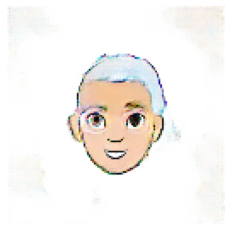

In [73]:

plt.axis("off")
plt.imshow((image_genereted * 255).astype("int32")[0])
    


In [74]:
#Genereted 12 images

batch_size = 1
latent_dim = 128
images_genereted = generator.predict(image_random)

In [36]:
# fonction dash

import plotly.graph_objs as go

def image_Genereted(n):
    generator.compile()
    batch_size = n
    latent_dim = 128
    image_random = np.random.normal(size=(batch_size,latent_dim))
    image_genereted = generator.predict(image_random)
    return image_genereted

 


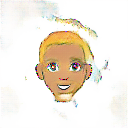

In [63]:
image1 = image_Genereted(1)
image1.shape
for x in image1 : 
    #px.axis("off")
    fig = px.imshow((x*255).astype(np.uint8))
    fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


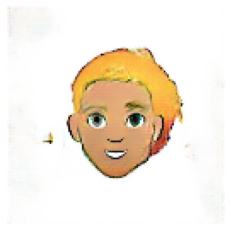

In [49]:
plt.axis("off")
plt.imshow((image1 * 255).astype("int32")[0])
    


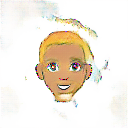

In [64]:
import plotly.express as px
import numpy as np


fig = px.imshow((x*255).astype(np.uint8))
fig.show()